In [1]:
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split 
from torch.utils.data.dataloader import DataLoader 

# Tutorial: https://jovian.ai/aakashns/05-cifar10-cnn

# Importing image data
Each folder of images is imoprted with appropriate classification data, and as either a training or a test set.

In [2]:
#Define your data directory Training set classes
data_dir = './data/'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['shoe', 'airplane', 'spoon', 'bicycle', 'coffee_cup']


In [3]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
print(dataset.classes)

['airplane', 'bicycle', 'coffee_cup', 'shoe', 'spoon']


torch.Size([3, 28, 28]) 0
Label:  shoe (3)


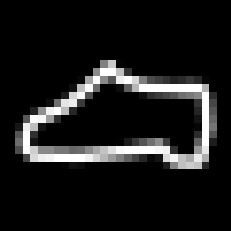

In [5]:
# Create an image generator to test if data was loaded properly 
img, label = dataset[0]
print(img.shape, label)
img

# Define a fucntion to display a random image from the Training set 
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')

show_example(*dataset[random.randint(0,40000)])

# Splitting our data set into training and validation sets
 Using the random_split function from PyTorch, we need to split off a small portion of our training set to use a validation set.  To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

In [6]:
## ds = dataset, dl = dataloader
seed = 51
torch.manual_seed(seed)

validate_size = 4000
train_size = len(dataset) - validate_size

train_ds, validate_ds = random_split(dataset, [train_size, validate_size])
print(len(train_ds), len(validate_ds))

36000 4000


In [7]:
#Creating the DataLoaders
batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
validate_dl = DataLoader(validate_ds, batch_size*2, num_workers=4, pin_memory=True)

In [8]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

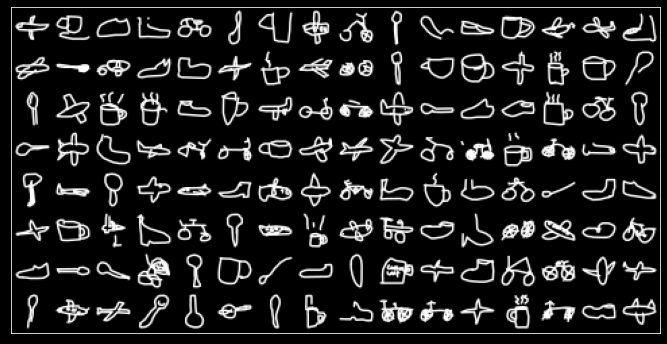

In [9]:
show_batch(train_dl)

# Defining the Convolutional Neural Network Model 
The `Conv2d` layer transforms a 3-channel image to a 16-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 5 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [10]:
# defining the model by extending an ImageClassificationBase class which contains 
# helper methods for training & validation.

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
# Extended the ImageClassificationBase class with our specific dataset 

class GoogleQuickdrawModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #FIRST CHAIN OF LAYERS GO FROM 3 TO 64 OUTPTU CHANNELS
            # input: 3 x 28 x 28
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            # output: 28 x 28 x 28 
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 14 x 14

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 7 x 7


            #Take the final output feature map and flatten it into a vecotr
            nn.Flatten(), 
            nn.Linear(128*7*7, 896),
            nn.ReLU(),
            nn.Linear(896, 448),
            nn.ReLU(),
            nn.Linear(448, 5))
        
    def forward(self, xb):
        return self.network(xb)

In [12]:
model = GoogleQuickdrawModel()
print(model)

GoogleQuickdrawModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=6272, out_features=896, bias=True)
    (12): ReLU()
    (13): Linear(in_features=896, out_features=448, bias=True)
    (14): ReLU()
    (15): Linear(in_features=448, out_features=5, bias=True)
  )
)


In [13]:
# Confirm that we get the expected output on a batch of training data 
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 28, 28])
out.shape: torch.Size([128, 5])
out[0]: tensor([ 0.0168,  0.0023, -0.0048,  0.0334, -0.0412],
       grad_fn=<SelectBackward0>)


# Boiler plate functions to allow code to run if GPU is available 

In [14]:
def get_default_device():
    """
    Pick GPU if available, else CPU
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """
    Move tensors to chosen device
    """
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """
    Wrap a dataloader to move data to a device
    """
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cpu')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
validate_dl = DeviceDataLoader(validate_dl, device)
to_device(model, device)

GoogleQuickdrawModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=6272, out_features=896, bias=True)
    (12): ReLU()
    (13): Linear(in_features=896, out_features=448, bias=True)
    (14): ReLU()
    (15): Linear(in_features=448, out_features=5, bias=True)
  )
)

# Training the Model

In [17]:
# Defining an evaluation and a training function

### no grad tells pytorch not to use gradient descent when evaluating (only use when training)
@torch.no_grad()
def evaluate(model, validate_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in validate_loader]
    return model.validation_epoch_end(outputs)

### THIS IS PRETTY BOILER PLATE!!! Uses generic parts so that you create in earlier steps. 
    # Theoretically you can use this for many models to come! 
def fit(epochs, lr, model, train_loader, validate_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        #Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        # Need to use different parameters for evaluating, i.e. no randomizing
        result = evaluate(model, validate_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
model = to_device(model, device)

In [19]:
# This is evaluating prior to training!! 
# Here we produce an accuracy rate of around 20%, or 1 in 5. 
# This is because this model is as good as random, and randoly assigns from 5 classes.
evaluate(model, validate_dl)

{'val_loss': 1.6104029417037964, 'val_acc': 0.192626953125}

In [20]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = .001

In [21]:
history = fit(num_epochs, lr, model, train_dl, validate_dl, opt_func)

Epoch [0], train_loss: 0.3092, val_loss: 0.1835, val_acc: 0.9472
Epoch [1], train_loss: 0.1323, val_loss: 0.1570, val_acc: 0.9546
Epoch [2], train_loss: 0.1052, val_loss: 0.1438, val_acc: 0.9588
Epoch [3], train_loss: 0.0790, val_loss: 0.1398, val_acc: 0.9569
Epoch [4], train_loss: 0.0615, val_loss: 0.1701, val_acc: 0.9558


# Visualizng Model Performance 

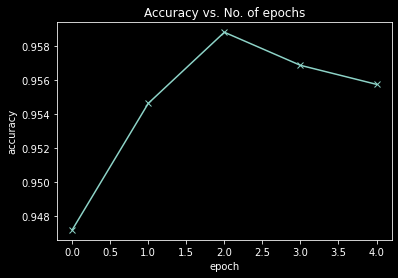

In [22]:
# Plotting classification accuracies
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
plot_accuracies(history)

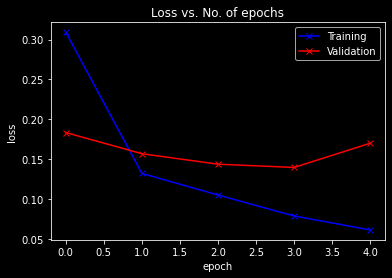

In [29]:
# Plotting loss accuracy
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
plot_losses(history)

# Individual Image Testing

In [24]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())
print(test_dataset.classes)

['airplane', 'bicycle', 'coffee_cup', 'shoe', 'spoon']


In [25]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: coffee_cup , Predicted: coffee_cup


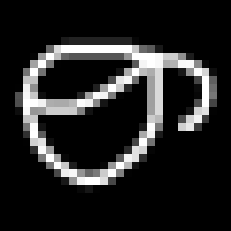

In [30]:
img, label = test_dataset[random.randint(0,10000)]
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [27]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.03336873650550842, 'val_acc': 1.0}

# Saving the model 

In [28]:
torch.save(model.state_dict(), 'GoogleQuickDraw_CNN.pth')

In [ ]:
#To import with same state_dict
### re_model = to_device(GoogleQuickdrawModel(), device)
### re_model.load_state_dict(torch.load('GoogleQuickDraw_CNN.pth'))